In [1]:
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 47.0 MB/s eta 0:00:00


In [2]:
from collections import OrderedDict
from typing import Dict, Tuple
from flwr.common import NDArrays, Scalar
from torch.optim.lr_scheduler import ExponentialLR
import torch
import flwr as fl
import pickle
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F

In [73]:
class LeNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train(net, trainloader, optimizer, epochs, device: str, schedule):
    citertion = torch.nn.CrossEntropyLoss()
    net.train()
    net.to(device)
    for _ in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = citertion(net(images), labels)
            loss.backward()
            optimizer.step()
        schedule.step()


def test(net, testloader, device: str):
    citertion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    net.to(device)
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            output = net(images)
            loss += citertion(output, labels).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct/len(testloader.dataset)
    return loss, accuracy

In [74]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, vallodaer, num_classes) -> None:
        super().__init__()
        self.trainloader = trainloader
        self.valloader = vallodaer
        self.model = LeNet(num_classes)
        # lựa chọn thiết bị để xử lý là gpu hoặc cpu
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu")

    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract model parameters and return them as a list of numpy arrays."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        lr = config["lr"]
        momentum = config["momentum"]
        epochs = config["local_epochs"]
        optim = torch.optim.SGD(self.model.parameters(),
                                lr=lr)
        # Sử dụng decays exponentially rate = 0.995 để điều chỉnh learning rate
        schedule = ExponentialLR(optim, gamma=0.995)
        # Thực hiện quá trình local training
        train(self.model, self.trainloader, optim,
              epochs, self.device, schedule)

        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        self.set_parameters(parameters)

        loss, accuracy = test(self.model, self.valloader, self.device)

        return float(loss), len(self.valloader), {"accuracy": accuracy}


def generate_client_fn(trainloaders, valloaders, num_classes):
    def client_fn(cid: str):
        return FlowerClient(
            trainloader=trainloaders[int(cid)],
            vallodaer=valloaders[int(cid)],
            num_classes=num_classes,
        )
    return client_fn

In [75]:
def get_on_fit_config(lr, momentum, local_epochs, decays_exponentially):
    def fit_config_fn(server_round: int):
        return {'lr': lr, 'momentum': momentum,
                'local_epochs': local_epochs}
    return fit_config_fn


def get_evaluate_fn(num_classes: int, testloader):
    def evaluate_fn(server_round: int, parameter, config):
        model = LeNet(num_classes)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        params_dict = zip(model.state_dict().keys(), parameter)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        loss, accuracy = test(model, testloader, device)

        return loss, {'accuracy': accuracy}

    return evaluate_fn

In [83]:
from torchvision import datasets, transforms

def split_noniid(train_idcs, train_labels, alpha, n_clients):
    n_classes = train_labels.max()+1
    label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes)

    class_idcs = [np.argwhere(train_labels[train_idcs]==y).flatten()
           for y in range(n_classes)]

    client_idcs = [[] for _ in range(n_clients)]
    for c, fracs in zip(class_idcs, label_distribution):
        for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1]*len(c)).astype(int))):
            client_idcs[i] += [idcs]

    client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]

    return client_idcs


class CustomSubset(Subset):
    '''A custom subset class with customizable data transformation'''
    def __init__(self, dataset, indices, subset_transform=None):
        super().__init__(dataset, indices)
        self.subset_transform = subset_transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]

        if self.subset_transform:
            x = self.subset_transform(x)

        return x, y

In [47]:
num_rounds = 5
num_clients = 40
num_clients_per_round_fit = 12
num_clients_per_round_eval = 12
num_classes = 10
batch_size = 16
lr =  0.01
momentum =  0.995
local_epochs =  5
decays_exponentially = 0.995

In [91]:
DIRICHLET_ALPHA = 1.0

# Load MNIST dataset
tr = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
traindata = datasets.MNIST(root=".", train=True, download=True, transform=tr)
testdata = datasets.MNIST(root=".", train=False, download=True, transform=tr)
testloaders = DataLoader(testdata, batch_size)

# Mapping for labels to characters
mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

idcs = np.random.permutation(len(traindata))
train_idcs, val_idcs = idcs[:54000], idcs[54000:60000]
train_labels = traindata.train_labels.numpy()

train_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=num_clients)
val_idcs = split_noniid(val_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=num_clients)

train_data = [CustomSubset(traindata, idcs) for idcs in client_idcs]
val_data = [CustomSubset(traindata, idcs) for idcs in client_idcs]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [93]:
trainloaders = []
valloaders = []
for trainset_ in train_data:
      trainloaders.append(DataLoader(trainset_, batch_size=batch_size, shuffle=False, num_workers=2))

for valset_ in val_data:
      valloaders.append(DataLoader(valset_, batch_size=batch_size, shuffle=False, num_workers=2) )

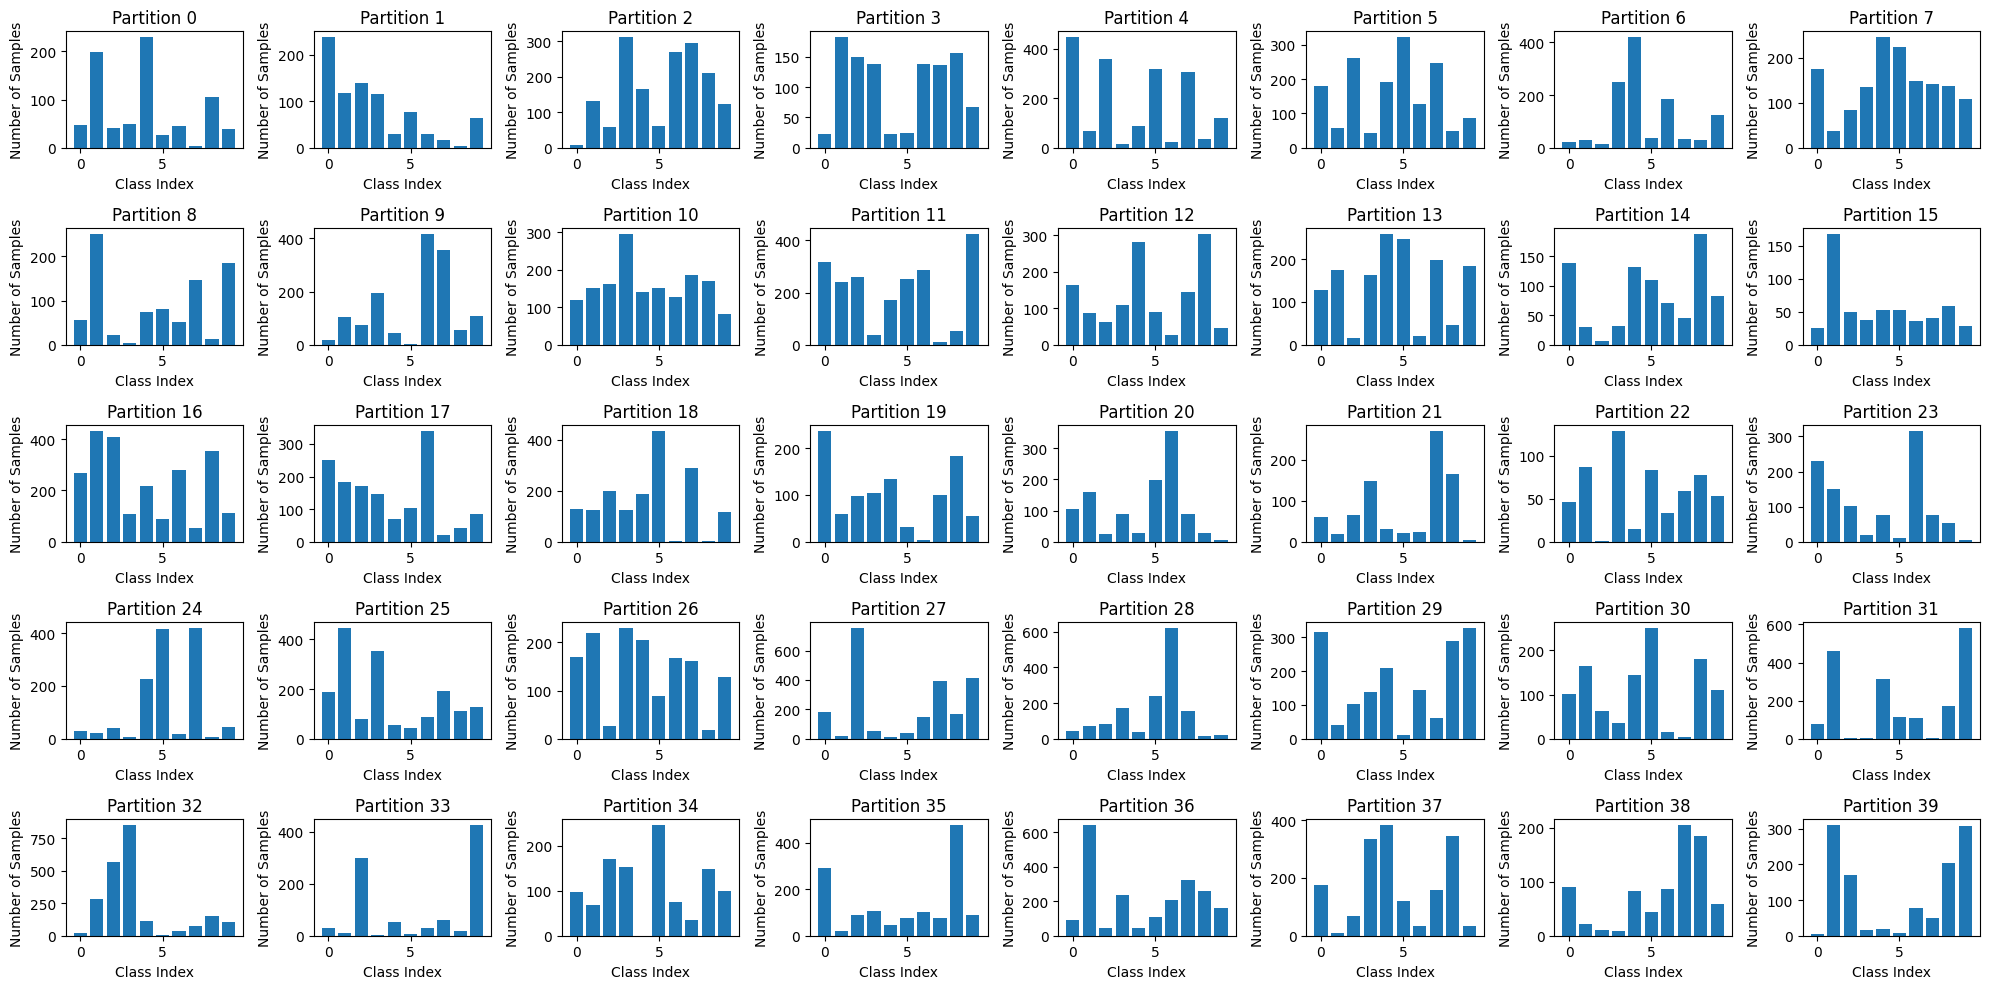

In [97]:
import matplotlib.pyplot as plt

# Assuming trainset is your original dataset
num_partitions = len(trainloaders)

# Function to get class distribution in a dataset
def get_class_distribution(dataset):
    class_distribution = {}
    for _, label in dataset:
        if label not in class_distribution:
            class_distribution[label] = 0
        class_distribution[label] += 1
    return class_distribution

# Create a 4x8 grid of subplots
fig, axes = plt.subplots(5, 8, figsize=(20, 10))

# Plot class distribution for each partition
for i, trainloader in enumerate(trainloaders):
    dataset = trainloader.dataset
    class_distribution = get_class_distribution(dataset)

    # Convert 2D index to 1D index for subplot
    row = i // 8
    col = i % 8

    axes[row, col].bar(class_distribution.keys(), class_distribution.values())
    axes[row, col].set_title(f'Partition {i}')
    axes[row, col].set_xlabel('Class Index')
    axes[row, col].set_ylabel('Number of Samples')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [94]:
# Define client
client_fn = generate_client_fn(trainloaders, valloaders, num_classes)

# Define strategy server
strategy = fl.server.strategy.FedAvg(fraction_fit = 0.0001, min_fit_clients = num_clients_per_round_fit,
                                         fraction_evaluate=0.0001,
                                         min_evaluate_clients = num_clients_per_round_eval,
                                         min_available_clients = num_clients,
                                         on_fit_config_fn = get_on_fit_config(
                                              lr =  0.01,
                                              momentum =  0.995,
                                              local_epochs =  5,
                                              decays_exponentially = 0.995 ),
                                         evaluate_fn=get_evaluate_fn(num_classes, testloaders))

In [95]:
history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
)

INFO flwr 2023-11-23 17:41:41,340 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-23 17:41:46,736	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-23 17:41:49,270 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3907199385.0, 'memory': 7814398772.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3907199385.0, 'memory': 7814398772.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-11-23 17:41:49,277 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-11-23 17:41:49,292 | app.py:224 | Flower VCE: Resources for each Virtual Clie

In [96]:
history

History (loss, distributed):
	round 1: 211.56450562554463
	round 2: 179.55676326138698
	round 3: 145.25983972965201
	round 4: 115.35700851398364
	round 5: 77.53628512435316
History (loss, centralized):
	round 0: 1439.1600060462952
	round 1: 1361.7851192951202
	round 2: 1148.6278166770935
	round 3: 994.9942253232002
	round 4: 740.8760784715414
	round 5: 548.7098350673914
History (metrics, centralized):
{'accuracy': [(0, 0.1077), (1, 0.1015), (2, 0.2508), (3, 0.4297), (4, 0.5795), (5, 0.6778)]}

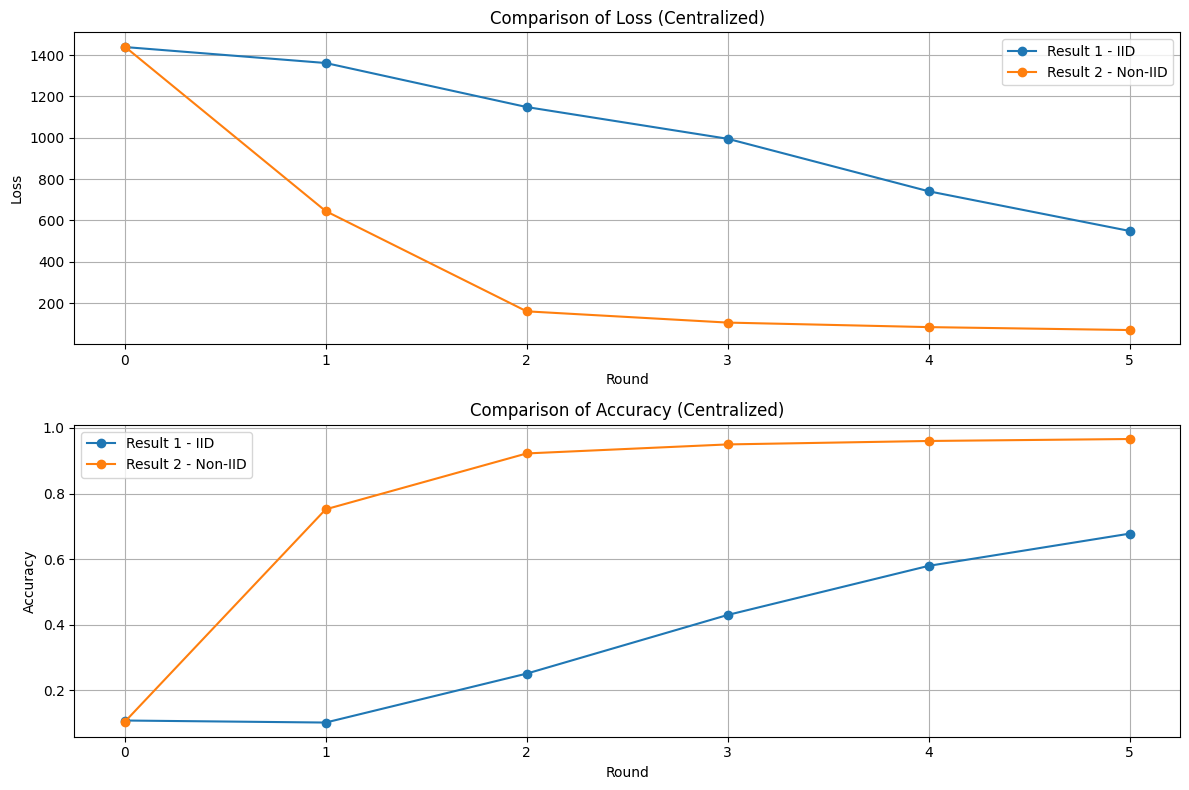

In [102]:
# Kết quả 1
rounds_distributed_1 = [1, 2, 3, 4, 5]
loss_distributed_1 = [211.56450562554463, 179.55676326138698, 145.25983972965201, 115.35700851398364, 77.53628512435316]

rounds_centralized_1 = [0, 1, 2, 3, 4, 5]
loss_centralized_1 = [1439.1600060462952, 1361.7851192951202, 1148.6278166770935, 994.9942253232002, 740.8760784715414, 548.7098350673914]
accuracy_centralized_1 = [0.1077, 0.1015, 0.2508, 0.4297, 0.5795, 0.6778]

# Kết quả 2
rounds_distributed_2 = [1, 2, 3, 4, 5]
loss_distributed_2 = [10.676379765073458, 2.698779345412428, 1.7765668497498457, 1.5416739621238473, 1.2968724869036425]

rounds_centralized_2 = [0, 1, 2, 3, 4, 5]
loss_centralized_2 = [1441.6401364803314, 645.1224765479565, 159.7711840318516, 105.33290213393047, 83.43573290482163, 69.23352128081024]
accuracy_centralized_2 = [0.1033, 0.7519, 0.9224, 0.9499, 0.9604, 0.9664]

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 2)
plt.plot(rounds_centralized_1, accuracy_centralized_1, label='Result 1 - IID', marker='o')
plt.plot(rounds_centralized_2, accuracy_centralized_2, label='Result 2 - Non-IID', marker='o')

plt.title('Comparison of Accuracy (Centralized)')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
# Loss, Centralized
plt.subplot(2, 1, 1)
plt.plot(rounds_centralized_1, loss_centralized_1, label='Result 1 - IID', marker='o')
plt.plot(rounds_centralized_2, loss_centralized_2, label='Result 2 - Non-IID', marker='o')
plt.title('Comparison of Loss (Centralized)')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
